# Check runtime device

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!nvidia-smi

Thu Dec 26 04:29:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# additional info when using cuda
if device.type == 'cuda':
    print('Device name: ', torch.cuda.get_device_name(0))
    # print(torch.cuda.memory_summary(device, abbreviated=False))

Using device: cuda
Device name:  Tesla T4


# Set up Working directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
WORKING_DIR = '/content/drive/MyDrive/LAB05-xlav'

In [ ]:
import os

if not os.path.exists(WORKING_DIR):
    os.makedirs(WORKING_DIR)

%cd $WORKING_DIR

/content/drive/MyDrive/LAB05-xlav


# **1. Experiment with YOLOv7**




## Clone Yolov7 code

In [ ]:
!rm -rf 'yolov7'

In [ ]:
!git clone https://github.com/wa1mpls/yolov7.git

Cloning into 'yolov7'...
remote: Enumerating objects: 626, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 626 (delta 0), reused 2 (delta 0), pack-reused 620 (from 1)
Receiving objects: 100% (626/626), 42.35 MiB | 15.24 MiB/s, done.
Resolving deltas: 100% (305/305), done.
Updating files: 100% (110/110), done.


In [ ]:
%cd 'yolov7'

/content/drive/MyDrive/LAB05-xlav/yolov7


## Prepare the Chess Pieces Dataset - 640x640

Original link: https://universe.roboflow.com/junior-zyvtn/chess-pieces-d0yt3/dataset/12

In [ ]:
# Download the dataset from gdrive
!gdown '1oQZelBeMPrhXRil1kBy5CLR_Dqy92zJB'

Downloading...
From (original): https://drive.google.com/uc?id=1oQZelBeMPrhXRil1kBy5CLR_Dqy92zJB
From (redirected): https://drive.google.com/uc?id=1oQZelBeMPrhXRil1kBy5CLR_Dqy92zJB&confirm=t&uuid=c47f47f6-86f2-498e-b7a4-c57ab2695d59
To: /content/drive/MyDrive/LAB05-xlav/yolov7/ChessPieces_yolov7pytorch.zip
100% 104M/104M [00:00<00:00, 161MB/s]


In [ ]:
CUSTOM_DATA_DIR = 'chess'

In [ ]:
!rm -rf $CUSTOM_DATA_DIR
!unzip 'ChessPieces_yolov7pytorch.zip' -d $CUSTOM_DATA_DIR
!rm 'ChessPieces_yolov7pytorch.zip'

Archive:  ChessPieces_yolov7pytorch.zip
  inflating: chess/data.yaml         
  inflating: chess/__MACOSX/._data.yaml  
  inflating: chess/README.dataset.txt  
  inflating: chess/README.roboflow.txt  
   creating: chess/test/
   creating: chess/test/images/
   creating: chess/test/labels/
  inflating: chess/test/images/unnamed-91-_jpg.rf.3313095e1471c20f5b380342f0b10d40.jpg  
  inflating: chess/test/images/unnamed-2024-09-20T162950-004_jpg.rf.c1e63175908d482e9f03811a9e08c0f5.jpg  
  inflating: chess/test/images/unnamed-94-_jpg.rf.9be30b3168aeeadaf86aff20ca689d25.jpg  
  inflating: chess/test/images/unnamed-97-_jpg.rf.bb90f860edc38433ec6b7f7351f0a91f.jpg  
  inflating: chess/test/images/unnamed-2024-09-20T163338-763_jpg.rf.865b892877469d80dbd93e929cd7b218.jpg  
  inflating: chess/test/images/unnamed-86-_jpg.rf.37152c846ec0af5459495657f2e417d4.jpg  
  inflating: chess/test/images/unnamed-2024-09-20T163419-171_jpg.rf.0e09304bdde66bd508ea755e7dc2b054.jpg  
  inflating: chess/test/images/un

In [ ]:
# Reconstruct the 'chess' folder to
# - images
# ---- train
# ---- valid
# ---- test
# - labels
# ---- train
# ---- valid
# ---- test
# - train.txt (contains all path of the train images)
# - valid.txt (contains all path of the valid images)
# - test.txt (contains all path of the test images)

import os
import shutil


os.chdir(CUSTOM_DATA_DIR)

data_names = ['train', 'valid', 'test']

# Function to move and rename folders
def move_and_rename_folders(data_names):
    for name in data_names:
        # Rename and move image folders
        source_image_dir = os.path.join(name, 'images')
        dest_image_dir = os.path.join('images', name)
        os.makedirs(os.path.dirname(dest_image_dir), exist_ok=True)
        os.rename(source_image_dir, dest_image_dir)

        # Rename and move label folders
        source_label_dir = os.path.join(name, 'labels')
        dest_label_dir = os.path.join('labels', name)
        os.makedirs(os.path.dirname(dest_label_dir), exist_ok=True)
        os.rename(source_label_dir, dest_label_dir)

        # Create the txt file
        txt_file = name + '.txt'
        with open(txt_file, 'w') as f:
            for filename in os.listdir(dest_image_dir):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    f.write(f"{os.path.join('./images', name, filename)}\n")

move_and_rename_folders(data_names)

os.chdir("..")

In [ ]:
# Remove old directories
for dir_name in data_names:
  dir_path = os.path.join(CUSTOM_DATA_DIR, dir_name)
  if os.path.exists(dir_path):
    shutil.rmtree(dir_path)

## Download pre-trained weights

In [ ]:
%mkdir weights
!curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7_training.pt -o weights/yolov7_training.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 72.1M  100 72.1M    0     0  47.2M      0  0:00:01  0:00:01 --:--:-- 82.9M


## Demo

In [ ]:
!rm -rf runs/detect/

In [ ]:
!python detect.py --weights weights/yolov7_training.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg

Namespace(weights=['weights/yolov7_training.pt'], source='inference/images/horses.jpg', img_size=640, conf_thres=0.25, iou_thres=0.45, device='', view_img=False, save_txt=False, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='runs/detect', name='exp', exist_ok=False, no_trace=False)
YOLOR 🚀 b8fe34a torch 2.5.1+cu121 CUDA:0 (Tesla T4, 15102.0625MB)

/content/drive/MyDrive/LAB05-xlav/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no 

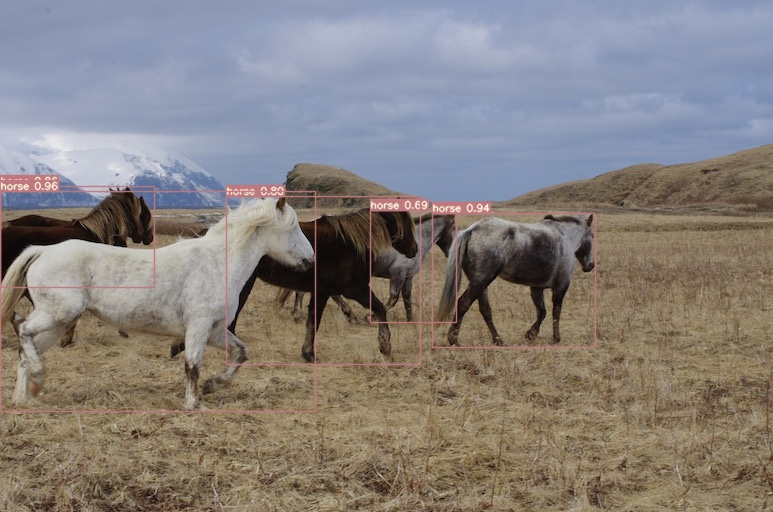

In [ ]:
from PIL import Image
Image.open('runs/detect/exp/horses.jpg')

## Training

In [ ]:
!rm -rf wandb runs/train runs/test

In [ ]:
!python train.py --workers 8 --device 0 --batch-size 8 --epochs 200 --data data/chess.yaml --img 640 640 --cfg cfg/training/yolov7-chess.yaml --weights 'weights/yolov7_training.pt' --name yolov7-chess --cache-images --hyp data/hyp.scratch.custom.yaml

2024-12-26 04:32:33.480735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-26 04:32:33.502025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-26 04:32:33.507939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 04:32:33.522451: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-26 04:32:34.585655: W tensorflow/comp

## TEST

In [ ]:
!python test.py --data ./data/chess.yaml --img 640 --batch 8 --conf-thres 0.02 --iou-thres 0.5 --device 0 --weights ./runs/train/yolov7-chess/weights/best.pt --name yolov7-chess

Namespace(weights=['./runs/train/yolov7-chess/weights/best.pt'], data='./data/chess.yaml', batch_size=8, img_size=640, conf_thres=0.02, iou_thres=0.5, task='val', device='0', single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project='runs/test', name='yolov7-chess', exist_ok=False, no_trace=False, v5_metric=False)
YOLOR 🚀 b8fe34a torch 2.5.1+cu121 CUDA:0 (Tesla T4, 15102.0625MB)

/content/drive/MyDrive/LAB05-xlav/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed d

# **2. Experiment with YOLOv11**

In [ ]:
%cd $WORKING_DIR

/content/drive/MyDrive/LAB05-xlav


## Install YOLOv11 via Ultralytics

In [ ]:
!rm -rf yolov11

In [ ]:
import os

os.makedirs('yolov11', exist_ok=True)
HOME = os.path.join(os.getcwd(), 'yolov11')
os.chdir(HOME)
os.getcwd()

'/content/drive/MyDrive/LAB05-xlav/yolov11'

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 37.8/112.6 GB disk)


## Demo with CLI

In [ ]:
!yolo task=detect mode=predict model=yolo11m.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

100% 38.8M/38.8M [00:01<00:00, 39.0MB/s]
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,091,712 parameters, 0 gradients, 68.0 GFLOPs

100% 104k/104k [00:00<00:00, 36.5MB/s]
image 1/1 /content/drive/MyDrive/LAB05-xlav/yolov11/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 2 backpacks, 97.3ms
Speed: 5.5ms preprocess, 97.3ms inference, 1123.8ms postprocess per image at shape (1, 3, 640, 384)
Results saved to runs/detect/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


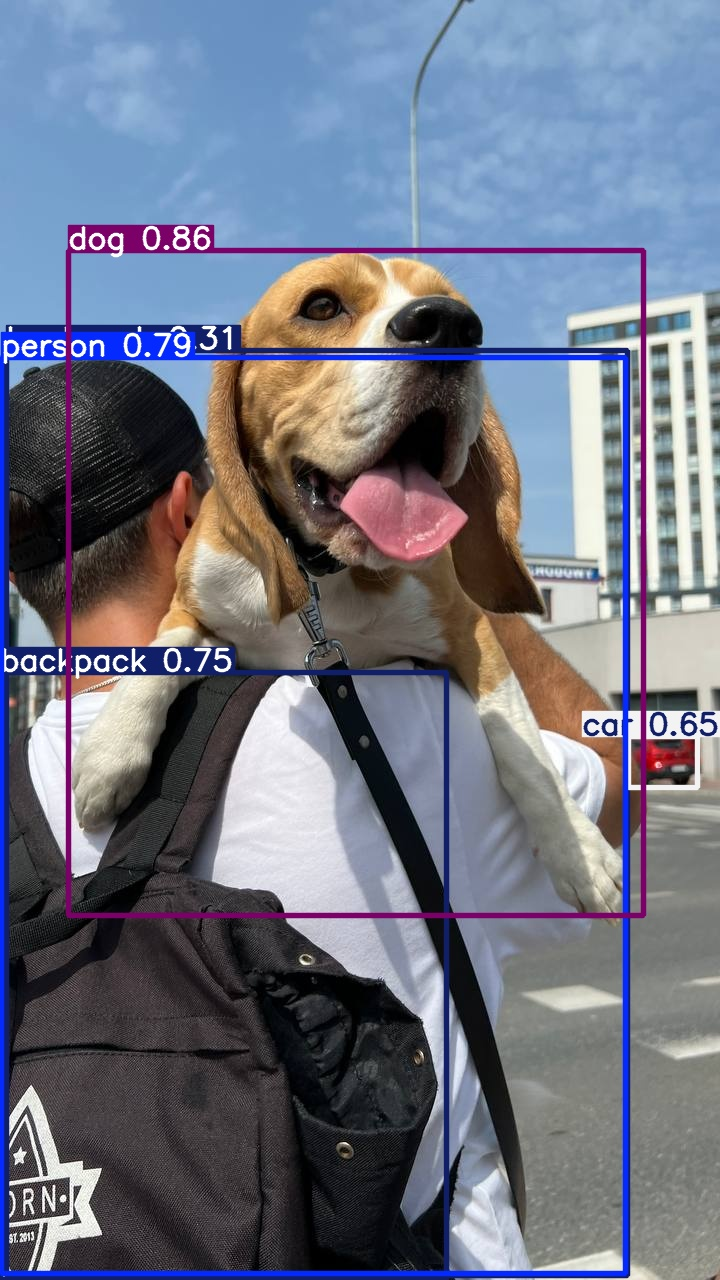

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/predict/dog.jpg', width=500)

## Fine-tune YOLOv11 with custom dataset: Chess Pieces Dataset - 640x640

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow
import getpass

ROBOFLOW_API_KEY = getpass.getpass("Enter your Roboflow API key: ")
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("junior-zyvtn").project("chess-pieces-d0yt3")
version = project.version(12)
dataset = version.download("yolov11")

/content/yolov11/datasets
Enter your Roboflow API key: ··········
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Chess-Pieces-12 in yolov11:: 100%|██████████| 176/176 [00:00<00:00, 518.80it/s]


## Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11m.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

/content/yolov11
New https://pypi.org/project/ultralytics/8.3.54 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/yolov11/datasets/Chess-Pieces-12/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

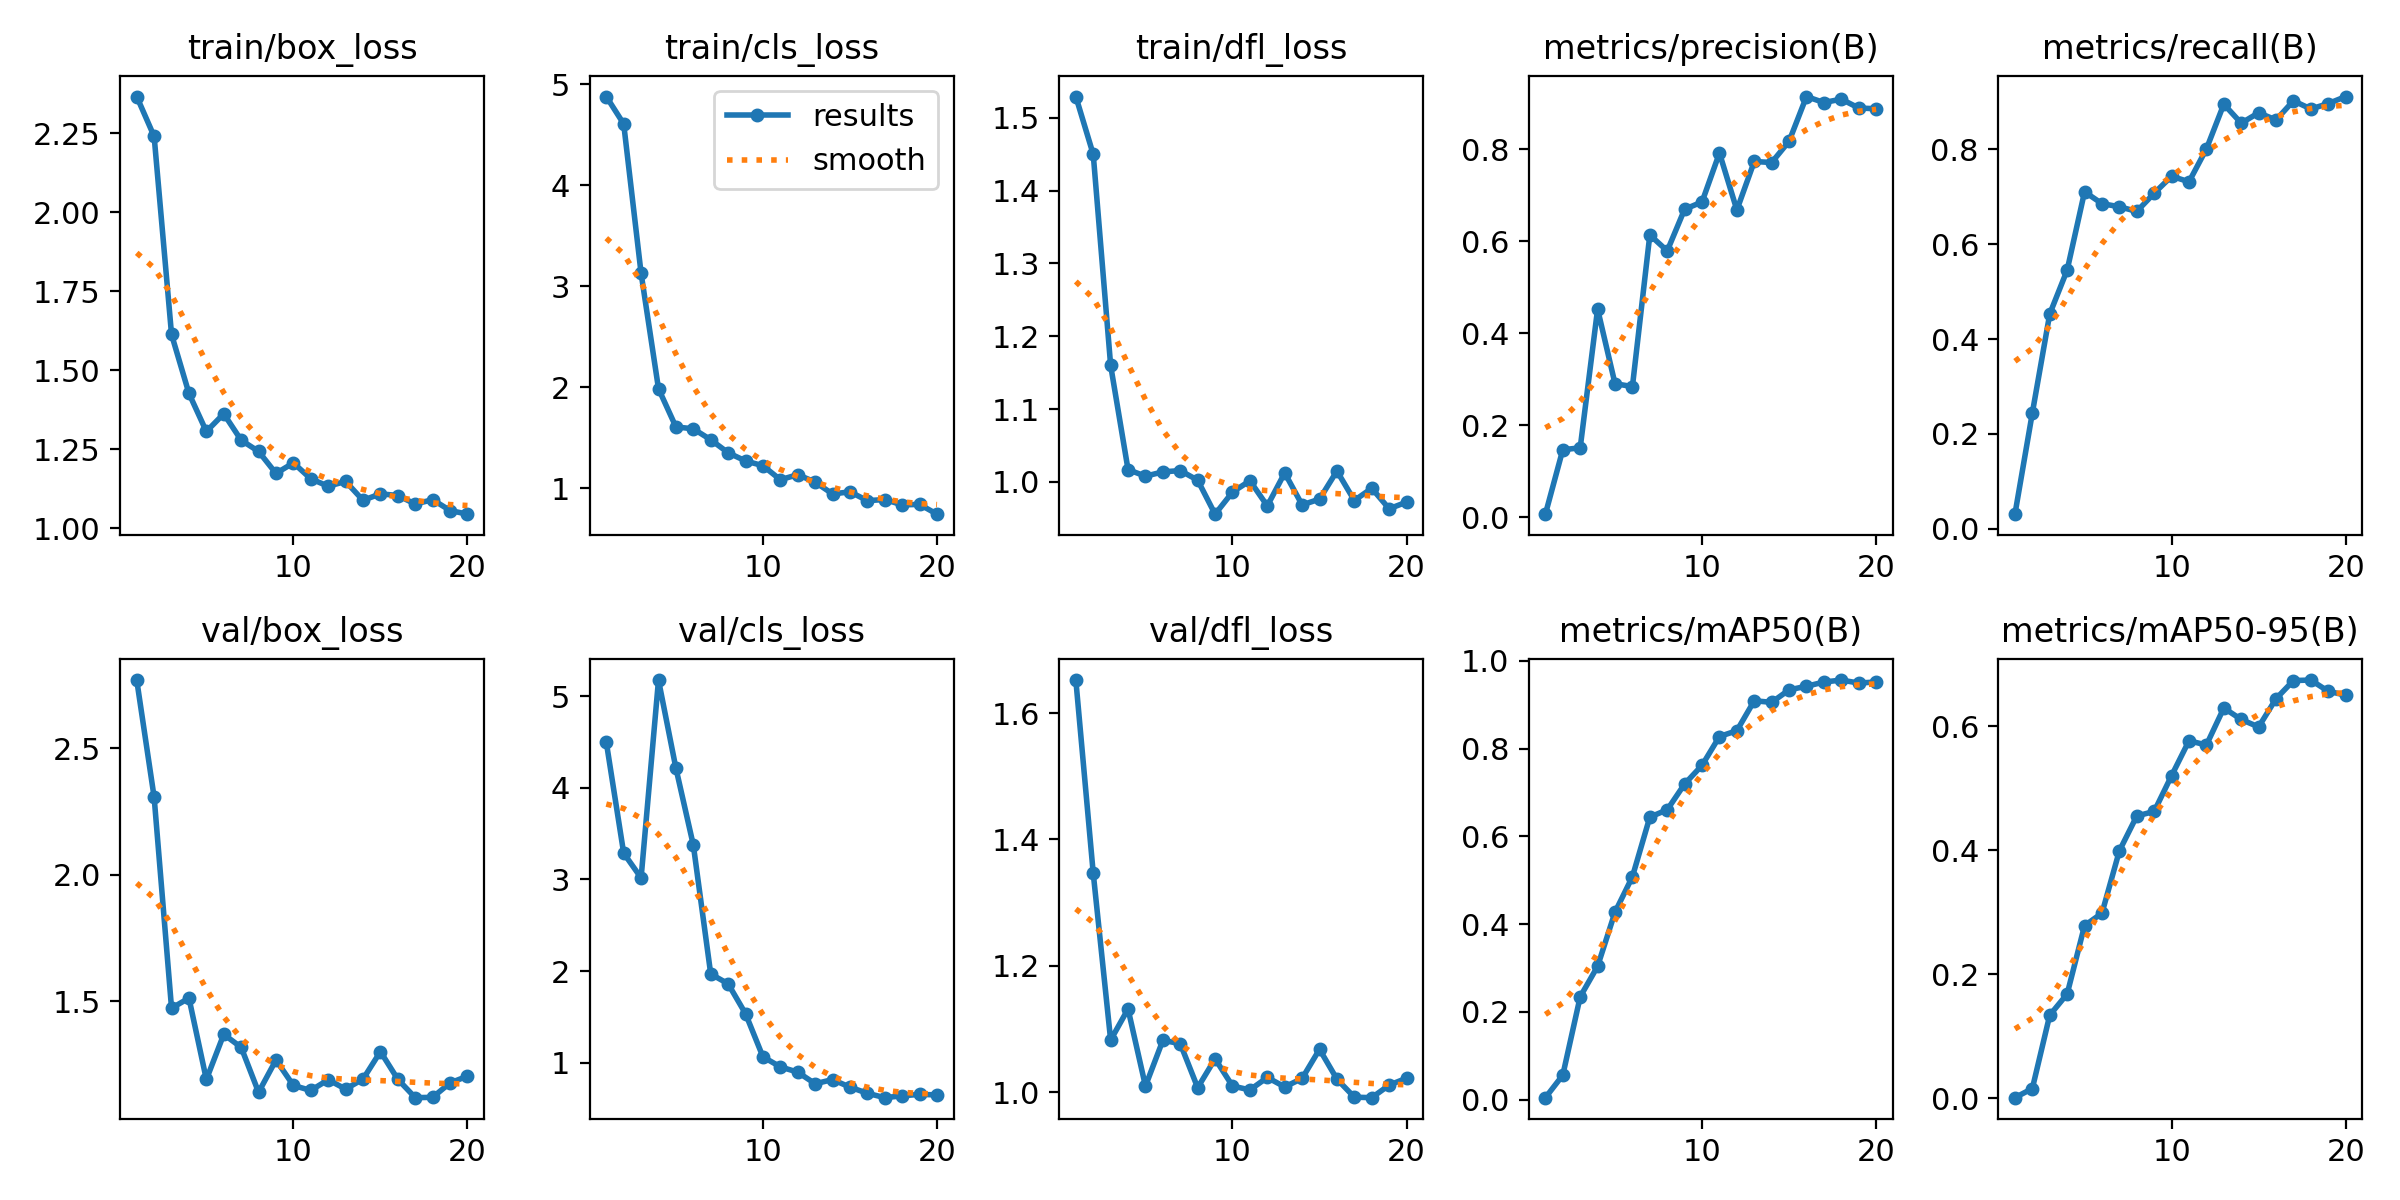

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=800)

## TEST

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,039,284 parameters, 0 gradients, 67.7 GFLOPs
val: Scanning /content/yolov11/datasets/Chess-Pieces-12/valid/labels.cache... 18 images, 0 backgrounds, 0 corrupt: 100% 18/18 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 2/2 [00:02<00:00,  1.39s/it]
                   all         18        341      0.909      0.885      0.956      0.673
          Brown Bishop         15         27      0.837      0.852      0.895      0.587
            Brown King         15         15      0.874        0.8      0.914      0.656
          Brown Knight          5         10          1      0.668      0.995      0.705
            Brown Pawn         14         83          1      0.911      0.995      0.712
           Brown Queen         14         14      0.821          1      0.958      0.677
            Brown Rook         1

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.1 source={HOME}/datasets/Chess-Pieces-12/test/images/unnamed-79-_jpg.rf.57cf7cd9d24d0f486564744a05d58a62.jpg save=True

Ultralytics 8.3.40 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,039,284 parameters, 0 gradients, 67.7 GFLOPs

image 1/1 /content/yolov11/datasets/Chess-Pieces-12/test/images/unnamed-79-_jpg.rf.57cf7cd9d24d0f486564744a05d58a62.jpg: 640x480 1 Brown Knight, 1 Brown Queen, 1 Brown Rook, 1 White King, 1 White Queen, 1 White Rook, 65.5ms
Speed: 4.4ms preprocess, 65.5ms inference, 696.4ms postprocess per image at shape (1, 3, 640, 480)
Results saved to runs/detect/predict2
💡 Learn more at https://docs.ultralytics.com/modes/predict


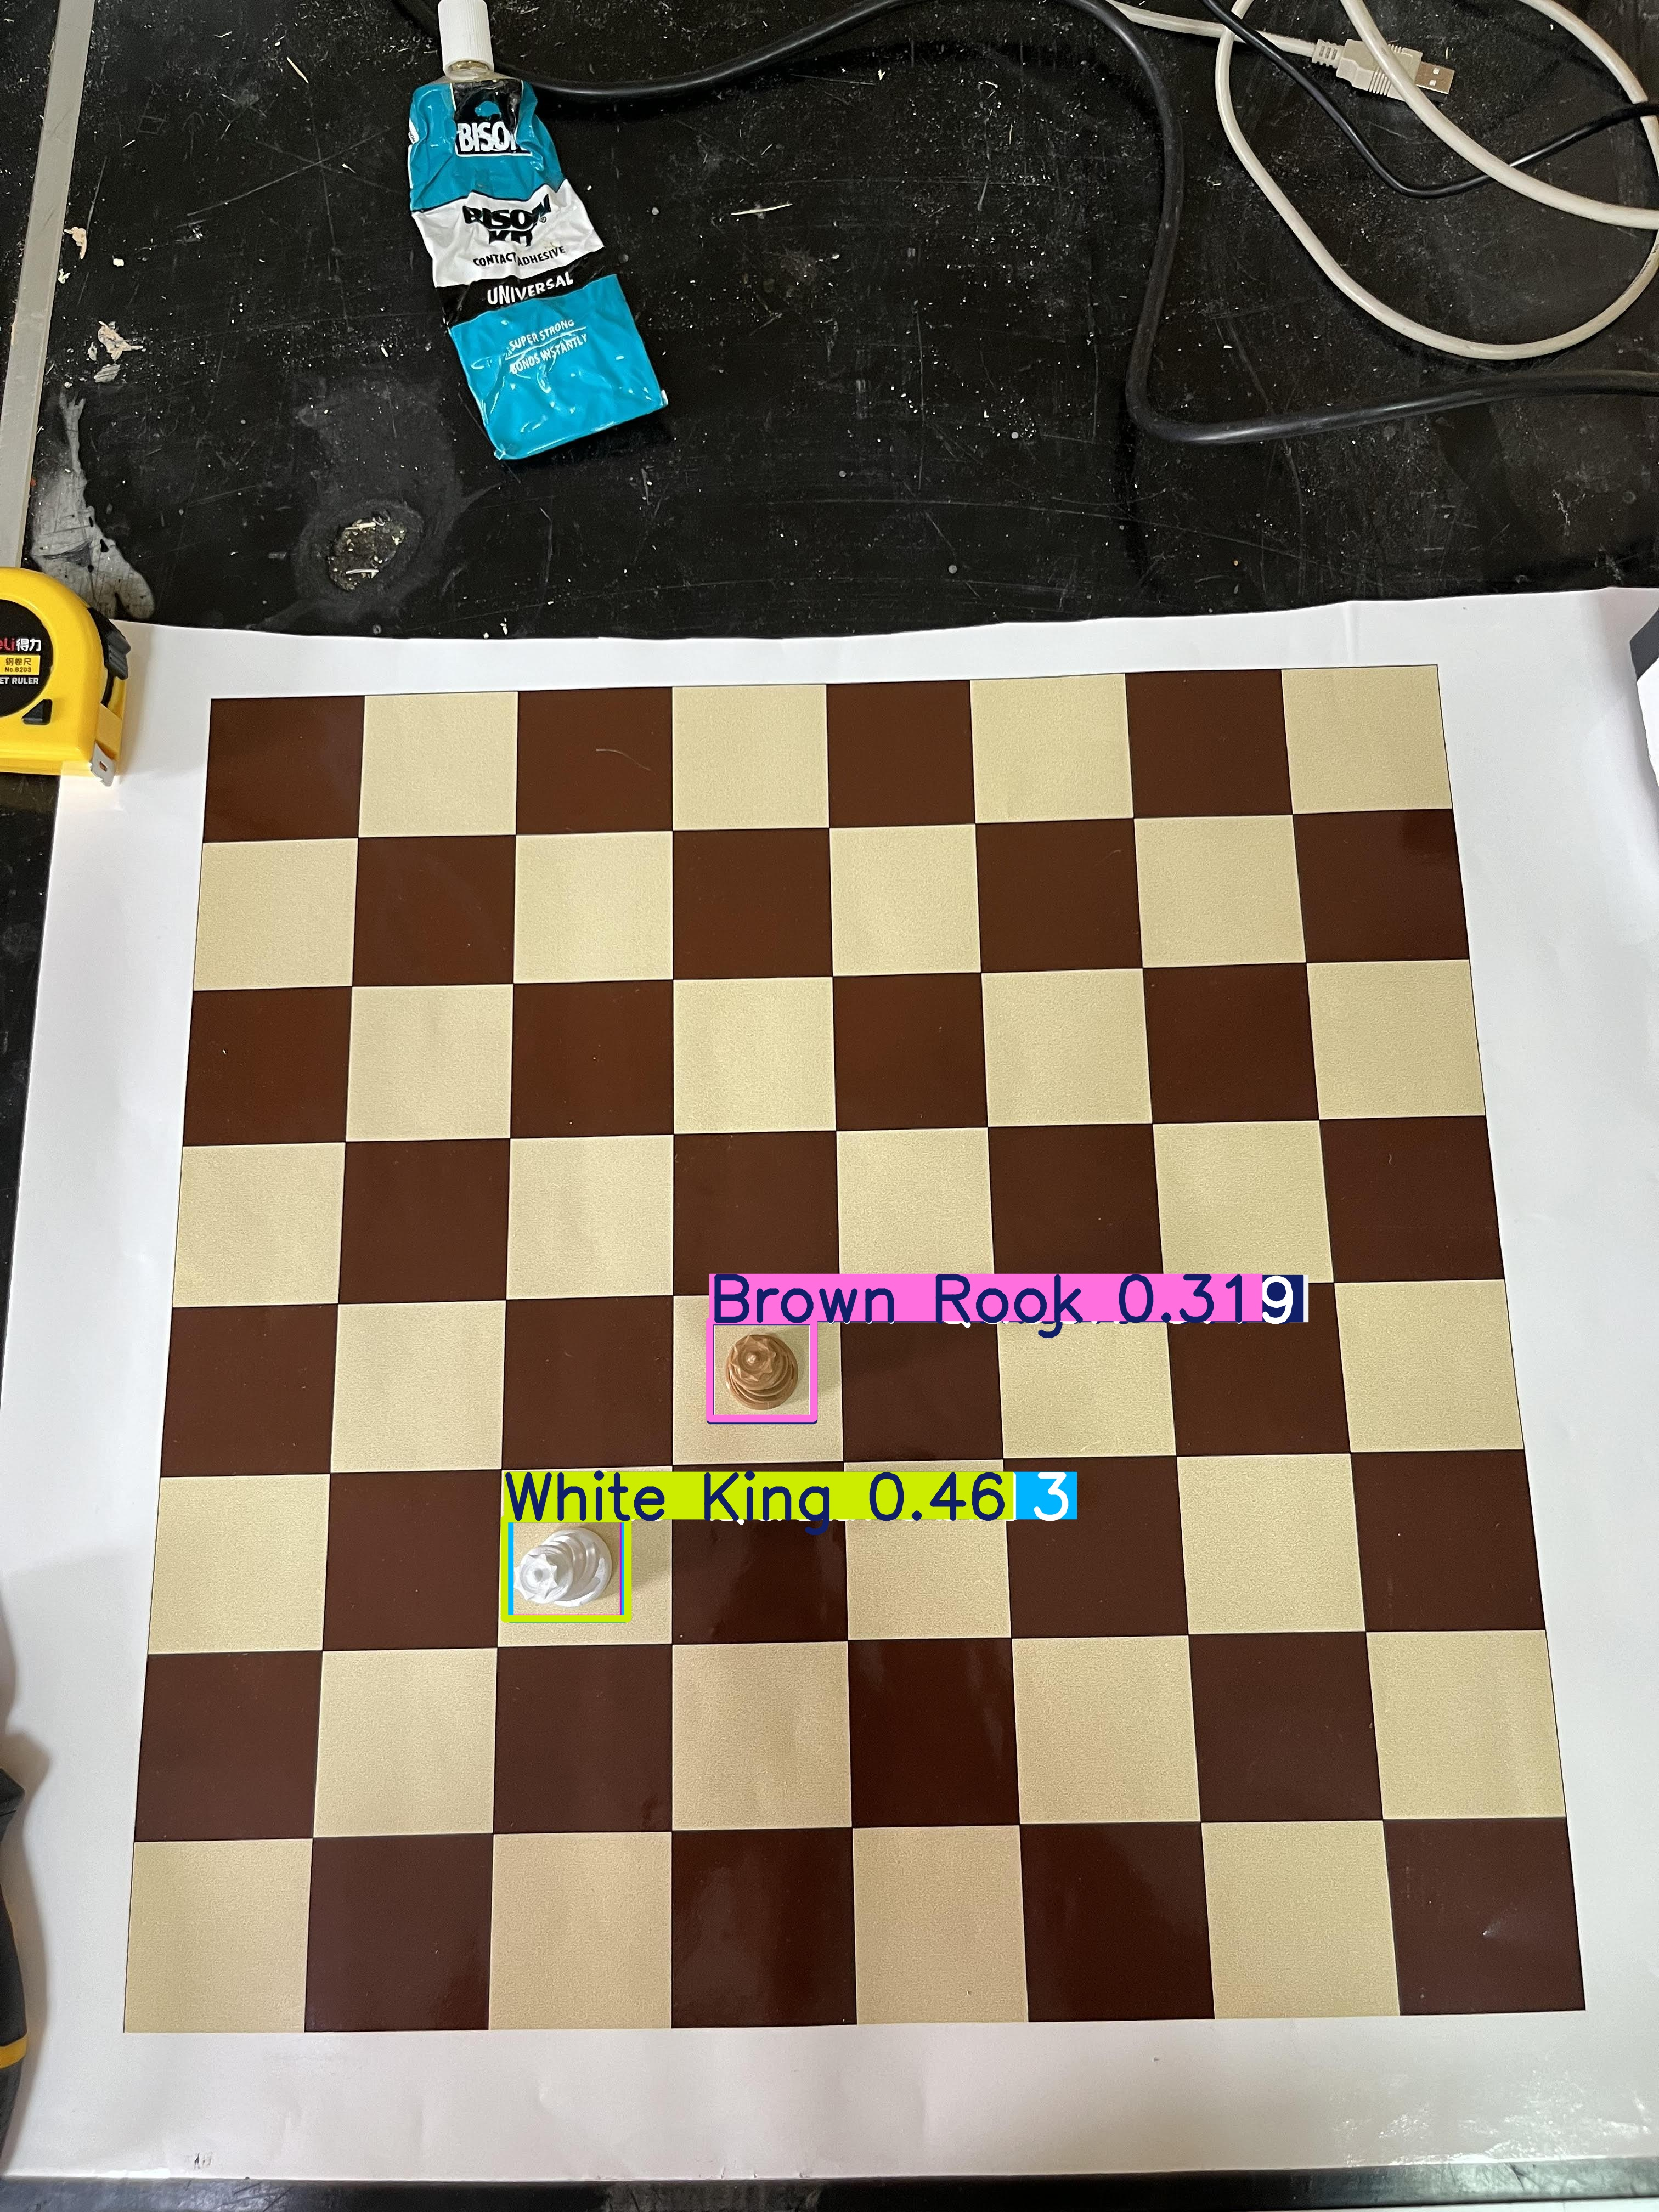

In [ ]:
IPyImage(filename=f'{HOME}/runs/detect/predict2/unnamed-79-_jpg.rf.57cf7cd9d24d0f486564744a05d58a62.jpg', width=500)